In [ ]:
#Medición del tiempo de inicio
import time

# Registrar el tiempo actual en el momento del inicio
inicio = time.time()

# Carga de Paquetes y Librerias

In [ ]:
# Basic packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import seaborn as sns
from pandas.plotting import scatter_matrix
from tabulate import tabulate
from numpy import array
import datetime as dt           # Permite trabajar con fechas

# Machine learning packages
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline


# Reducción de dimensiones
from sklearn.decomposition import PCA

# Regresión lineal
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

# Métricas de rendimiento
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, r2_score, mean_absolute_percentage_error
import scipy.stats as stats
from scipy.stats import pearsonr
from scipy.stats import ttest_ind
from scipy.stats import bartlett

# TensorFlow ≥2.0-preview is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Pretty print
from pprint import pprint

# SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Google
from google.colab import files  # Permite descargar archivos directamente desde Colab

# Ignorar advertencias
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', '.*do not.*', )

# Mostrar advertencia personalizada
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

In [ ]:
def TrainingSet(sequence, n_steps):
    """
		Parámetros:
        sequence (numpy.ndarray): La secuencia univariante que se va a dividir.
        n_steps (int): El número de pasos temporales a considerar para cada muestra.

    Retorna:
        numpy.ndarray: Matriz de muestras de entrada, cada una con n_pasos de tiempo.
        numpy.ndarray: Matriz de muestras de salida, cada una correspondiente al siguiente paso temporal.

    Descripción:
		Esta función toma una secuencia univariante y la divide en pares de entrada-salida
    adecuados para la previsión de series temporales. Crea muestras de entrada deslizando una ventana
    de tamaño n_pasos sobre la secuencia, y para cada ventana, extrae n_pasos de tiempo como entrada y el siguiente paso de tiempo como salida.
    como entrada y el siguiente paso temporal como salida.
    """
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence) - 1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# Carga de Base de Datos

In [ ]:
# Cargar datos de demanda energética comercial en Colombia desde Google Drive (acceso libre)

# Código de identificación del archivo en Google Drive
FILEID = "143FS8CtU4Wq1C6u43HMYyJC6QqktlZXM"  # Copiar el código desde el enlace generado en Google Drive

# Descargar el archivo utilizando wget y gestionar las cookies temporales
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O Departamentos.zip && rm -rf /tmp/cookies.txt

# Descomprimir el archivo descargado en el directorio principal de Colab
!unzip Departamentos.zip

# Mostrar el contenido del directorio actual
!dir

--2023-07-22 00:33:58--  https://docs.google.com/uc?export=download&confirm=t&id=143FS8CtU4Wq1C6u43HMYyJC6QqktlZXM
Resolving docs.google.com (docs.google.com)... 142.251.8.113, 142.251.8.139, 142.251.8.102, ...
Connecting to docs.google.com (docs.google.com)|142.251.8.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0o-6k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/mjpttqn670iund52jc5iqdanston4m3r/1689986025000/15940467605774616319/*/143FS8CtU4Wq1C6u43HMYyJC6QqktlZXM?e=download&uuid=e41203d3-7506-4c1d-8f7b-9abdc7f0fc7a [following]
--2023-07-22 00:33:59--  https://doc-0o-6k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/mjpttqn670iund52jc5iqdanston4m3r/1689986025000/15940467605774616319/*/143FS8CtU4Wq1C6u43HMYyJC6QqktlZXM?e=download&uuid=e41203d3-7506-4c1d-8f7b-9abdc7f0fc7a
Resolving doc-0o-6k-docs.googleusercontent.com (doc-0o-6k-docs.googleusercontent.com)... 64.233.188.132, 2404

In [ ]:
# Mostrar listado de elementos
!ls

 Colombia_Demanda_Horaria.xlsx   Departamentos.zip
 Colombia.xlsx                   sample_data/
 D_Departamental_Horaria.xlsx    Todos_Departamentos_Depurado.xlsx
'Demanda_Caribe Ajustado.xlsx'


In [ ]:
# Ruta del archivo de Excel que contiene los datos
archivo_excel = '/content/Colombia_Demanda_Horaria.xlsx'

# Leer los datos desde el archivo Excel y cargarlos en un DataFrame
df1 = pd.read_excel(archivo_excel)

# Eliminar la columna 'Date' del DataFrame
df1 = df1.drop('Date', axis=1)

# Generar un rango de fechas con frecuencia horaria y establecer un nuevo índice
date_rng = pd.date_range(start='2000-01-01', end='2023-01-01', freq='H')

# Establecer el índice del DataFrame a las fechas generadas, excluyendo la última fecha
df1.set_index(date_rng[0:-1], inplace=True)

# Mostrar información relevante del Dataframe
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 201624 entries, 2000-01-01 00:00:00 to 2022-12-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Demand  201624 non-null  float64
dtypes: float64(1)
memory usage: 3.1 MB


<Axes: title={'center': 'Demanda Energia Horaria en Colombia kWh/dia'}, xlabel='Fecha', ylabel='kWh'>

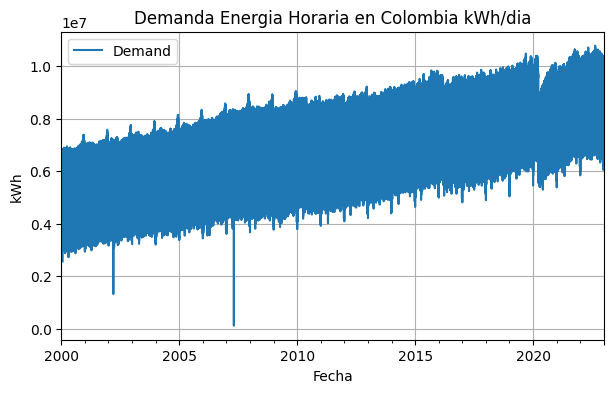

In [ ]:
# Plotting the Energy Demand Time Series
df1.plot(
    kind='line',
    figsize=(7, 4),
    title='Demanda Energia Horaria en Colombia kWh/dia',
    grid=True,
    ylabel='kWh',
    xlabel='Fecha',
    xlim=('2000-01-01', '2022-12-31')
)

<Axes: title={'center': 'Demanda Energia Horaria en Colombia kWh/dia'}, xlabel='Fecha', ylabel='kWh'>

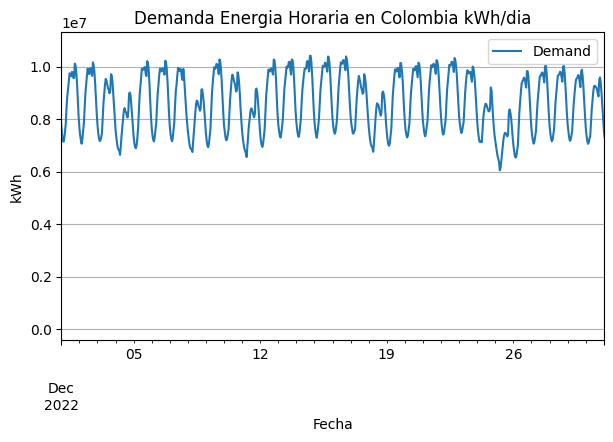

In [ ]:
# Plotting a Specific Time Range of the Energy Demand Time Series
df1.plot(
    kind='line',
    figsize=(7, 4),
    title='Demanda Energia Horaria en Colombia kWh/dia',
    grid=True,
    ylabel='kWh',
    xlabel='Fecha',
    xlim=('2022-12-01', '2022-12-31')
)

# Normalizacion


In [ ]:
# Extracción de un año de la serie horaria desde octubre de 2020 hasta diciembre de 2022
Ts1 = df1['2020-10-01':'2022-12-31'].values

# Impresión del tamaño de la serie horaria
print('Tamaño de la Serie Horaria: ', len(Ts1))

# Escalado de la serie horaria utilizando MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(Ts1)
Ts1 = scaler.transform(Ts1)

Tamaño Serie Horaria:  19728


# Modelos DL


## Time Step=6

### Conjunto de Entrenamiento

In [ ]:
# Definición del tamaño de ventana para el procesamiento secuencial
step_back = 6

# Creación de las particiones X, Y utilizando la función TrainingSet con el tamaño de ventana dado
X1, Y1 = TrainingSet(Ts1, step_back)

# Definición del porcentaje de partición Train-Test
Part = 0.8

# Creación de la partición para el conjunto de prueba (Test) y el conjunto de entrenamiento (Train) para la serie X
X_test1 = X1[int(len(X1) * 0.8):]
X_train1 = X1[:int(len(X1) * 0.8)]

# Creación de la partición para el conjunto de prueba (Test) y el conjunto de entrenamiento (Train) para la serie Y
Y_test1 = Y1[int(len(Y1) * 0.8):]
Y_train1 = Y1[:int(len(Y1) * 0.8)]

In [ ]:
# Imprimir los tamaños de los conjuntos de entrenamiento y prueba

# Imprimir el tamaño de X_train1 y Y_train1
print('Tamaño X_train1:', X_train1.shape, 'Tamaño Y_train1:', Y_train1.shape)

# Imprimir el tamaño de X_test1 y Y_test1
print('Tamaño X_test1:', X_test1.shape, 'Tamaño Y_test1:', Y_test1.shape)

# Imprimir una línea de separación
print('-----------------------------------------------------------------------')

Tamaño X_train1:  (15777, 6, 1) Tamaño Y_train1:  (15777, 1)
Tamaño X_test1:  (3945, 6, 1) Tamaño Y_test1:  (3945, 1)
-----------------------------------------------------------------------


In [ ]:
# Configuración de hiperparámetros para el entrenamiento de un modelo.

# Número de épocas (epochs) de entrenamiento.
N = 100

# Tamaño del lote (batch size) utilizado durante el entrenamiento.
bsz = 512

# Configuración de callbacks e impresión del tamaño de características.

# Configuración de callbacks para el entrenamiento del modelo.
callbacks = [
    keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_loss"),  # Guardar el mejor modelo
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=0.0001),  # Reducir la tasa de aprendizaje
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=7, verbose=1),  # Detener el entrenamiento temprano si no hay mejora
]

### LSTM

In [ ]:
# Creación del modelo de red neuronal LSTM (Long Short-Term Memory)
model_LSTM = keras.models.Sequential([
                                     keras.layers.LSTM(100, return_sequences=True, input_shape=(step_back,1)),
                                     keras.layers.LSTM(100, return_sequences=True),
                                     keras.layers.LSTM(100, return_sequences=True),
                                     keras.layers.LSTM(1)
])

# Resumen del modelo para mostrar la arquitectura y cantidad de parámetros
model_LSTM.summary()

# Compilación y configuración del proceso de entrenamiento del modelo LSTM
model_LSTM.compile(loss="mse", optimizer="adam", metrics=['mae', 'mse'])

# Entrenamiento del modelo LSTM utilizando los conjuntos de entrenamiento (X_train1, Y_train1)
# y con validación en un 20% de los datos (validation_split=0.2)
history = model_LSTM.fit(X_train1, Y_train1, epochs=N, batch_size=bsz, callbacks=callbacks, validation_split=0.2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 6, 100)            40800     
                                                                 
 lstm_5 (LSTM)               (None, 6, 100)            80400     
                                                                 
 lstm_6 (LSTM)               (None, 6, 100)            80400     
                                                                 
 lstm_7 (LSTM)               (None, 1)                 408       
                                                                 
Total params: 202,008
Trainable params: 202,008
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
25/25 [==============================] - 14s 76ms/step - loss: 0.1302 - mae: 0.2945 - mse: 0.1302 - val_loss: 0.0356 - val_mae: 0.1683 - val_mse: 0.0356 - lr: 0.0010
Ep

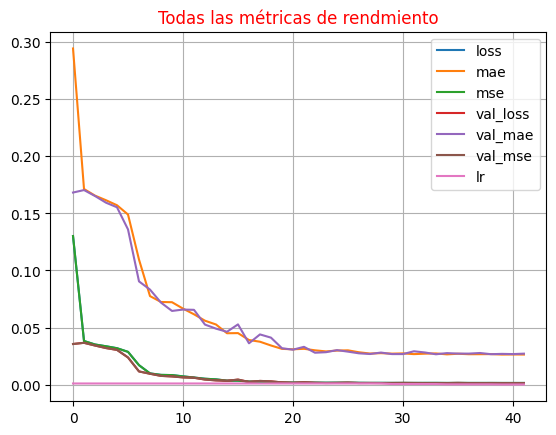

In [ ]:
# Visualización de métricas de rendimiento durante el entrenamiento.

# Crear un DataFrame a partir del historial de entrenamiento (history).
hpd = pd.DataFrame(history.history)

# Crear un gráfico de líneas para visualizar las métricas de rendimiento.
hpd.plot()

# Configuración del título y estilo del gráfico.
plt.title('Todas las métricas de rendimiento', color='red')
plt.grid(True)  # Mostrar cuadrícula en el fondo del gráfico

# Mostrar el gráfico.
plt.show()

### ANN

In [ ]:
# Definición, resumen y entrenamiento de un modelo de red neuronal densa (ANN).

# Definición de un modelo secuencial utilizando capas densas (Dense).
model_ANN = keras.models.Sequential([
    keras.layers.Dense(100,input_shape=(step_back,)),  # Capa densa con 100 unidades
    keras.layers.Dense(100),  # Otra capa densa con 100 unidades
    keras.layers.Dense(100),  # Otra capa densa con 100 unidades
    keras.layers.Dense(1)  # Capa densa de salida con 1 unidad
])
model_ANN.summary()

# Entrenamiento del modelo.

# Compilación del modelo con función de pérdida y optimizador.
model_ANN.compile(loss="mse", optimizer="adam", metrics=['mae', 'mse'])

# Entrenamiento del modelo utilizando los conjuntos de entrenamiento y validación definidos.
history = model_ANN.fit(X_train1, Y_train1, epochs=N, batch_size=bsz, validation_split=0.2)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 100)               700       
                                                                 
 dense_5 (Dense)             (None, 100)               10100     
                                                                 
 dense_6 (Dense)             (None, 100)               10100     
                                                                 
 dense_7 (Dense)             (None, 1)                 101       
                                                                 
Total params: 21,001
Trainable params: 21,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
25/25 [==============================] - 2s 11ms/step - loss: 0.0872 - mae: 0.2160 - mse: 0.0872 - val_loss: 0.0079 - val_mae: 0.0698 - val_mse: 0.0079 - lr: 0.0010
Epoch

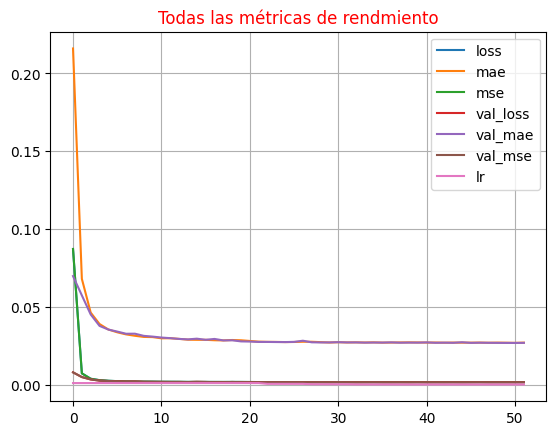

In [ ]:
# Visualización de métricas de rendimiento durante el entrenamiento.

# Crear un DataFrame a partir del historial de entrenamiento (history).
hpd = pd.DataFrame(history.history)

# Crear un gráfico de líneas para visualizar las métricas de rendimiento.
hpd.plot()

# Configuración del título y estilo del gráfico.
plt.title('Todas las métricas de rendimiento', color='red')
plt.grid(True)  # Mostrar cuadrícula en el fondo del gráfico

# Mostrar el gráfico.
plt.show()

### GRU

In [ ]:
# Creación del modelo de red neuronal GRU (Gated Recurrent Unit)
model_GRU = keras.models.Sequential([
                                     keras.layers.GRU(100, return_sequences=True, input_shape=(step_back,1)),
                                     keras.layers.GRU(100, return_sequences=True),
                                     keras.layers.GRU(100, return_sequences=True),
                                     keras.layers.GRU(1)
])

# Resumen del modelo para mostrar la arquitectura y cantidad de parámetros
model_GRU.summary()

# Compilación y configuración del proceso de entrenamiento del modelo GRU
metrics=['mae', 'mse']
model_GRU.compile(loss="mse", optimizer="adam", metrics=metrics)

# Entrenamiento del modelo GRU utilizando los conjuntos de entrenamiento (X_train1, Y_train1)
# y con validación en un 20% de los datos (validation_split=0.2)
history = model_GRU.fit(X_train1, Y_train1, epochs=N, batch_size=bsz, callbacks=callbacks, validation_split=0.2)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 6, 100)            30900     
                                                                 
 gru_1 (GRU)                 (None, 6, 100)            60600     
                                                                 
 gru_2 (GRU)                 (None, 6, 100)            60600     
                                                                 
 gru_3 (GRU)                 (None, 1)                 309       
                                                                 
Total params: 152,409
Trainable params: 152,409
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
25/25 [==============================] - 8s 58ms/step - loss: 0.0637 - mae: 0.1983 - mse: 0.0637 - val_loss: 0.0279 - val_mae: 0.1465 - val_mse: 0.0279 - lr: 0.0010
Epo

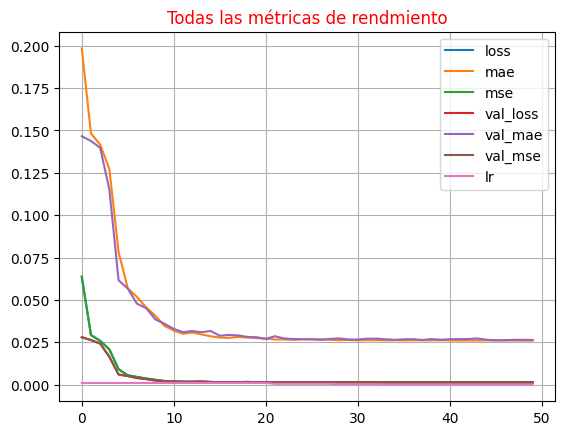

In [ ]:
# Visualización de métricas de rendimiento durante el entrenamiento.

# Crear un DataFrame a partir del historial de entrenamiento (history).
hpd = pd.DataFrame(history.history)

# Crear un gráfico de líneas para visualizar las métricas de rendimiento.
hpd.plot()

# Configuración del título y estilo del gráfico.
plt.title('Todas las métricas de rendimiento', color='red')
plt.grid(True)  # Mostrar cuadrícula en el fondo del gráfico

# Mostrar el gráfico.
plt.show()

### RNN

In [ ]:
# Creación del modelo de red neuronal RNN (SimpleRNN)
model_RNN = keras.models.Sequential([
                                     keras.layers.SimpleRNN(100, return_sequences=True, input_shape=(step_back,1)),
                                     keras.layers.SimpleRNN(100, return_sequences=True),
                                     keras.layers.SimpleRNN(100, return_sequences=True),
                                     keras.layers.SimpleRNN(1)
])

# Resumen del modelo para mostrar la arquitectura y cantidad de parámetros
model_RNN.summary()

# Compilación y configuración del proceso de entrenamiento del modelo RNN
metrics=['mae', 'mse']
model_RNN.compile(loss="mse", optimizer="adam", metrics=metrics)

# Entrenamiento del modelo RNN utilizando los conjuntos de entrenamiento (X_train1, Y_train1)
# y con validación en un 20% de los datos (validation_split=0.2)
history = model_RNN.fit(X_train1, Y_train1, epochs=N, batch_size=bsz, callbacks=callbacks, validation_split=0.2)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 6, 100)            10200     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 6, 100)            20100     
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 6, 100)            20100     
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 1)                 102       
                                                                 
Total params: 50,502
Trainable params: 50,502
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
25/25 [==============================] - 5s 48ms/step - loss: 0.2384 - mae: 0.4383 - mse: 0.2384 - val_loss: 0.0830 - val_mae: 0.2302 - val_mse: 0.0830 - lr: 0.0010
Epoch

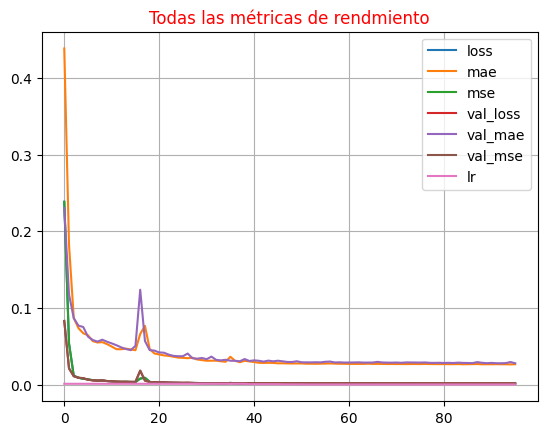

In [ ]:
# Visualización de métricas de rendimiento durante el entrenamiento.

# Crear un DataFrame a partir del historial de entrenamiento (history).
hpd = pd.DataFrame(history.history)

# Crear un gráfico de líneas para visualizar las métricas de rendimiento.
hpd.plot()

# Configuración del título y estilo del gráfico.
plt.title('Todas las métricas de rendimiento', color='red')
plt.grid(True)  # Mostrar cuadrícula en el fondo del gráfico

# Mostrar el gráfico.
plt.show()

## Medidas de Rendimiento

124/124 [==============================] - 0s 1ms/step


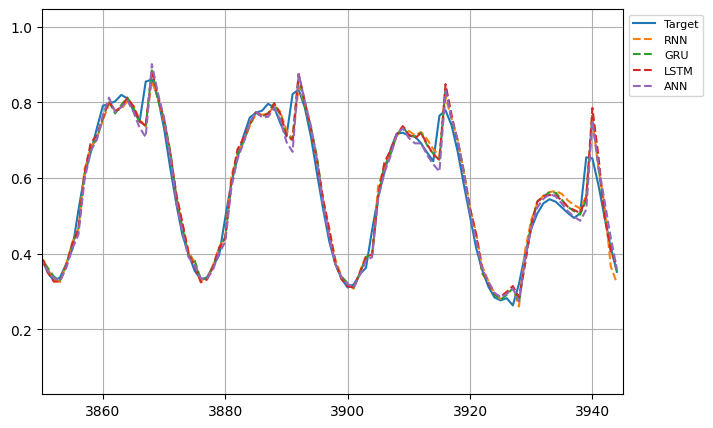

╒═════════════╤═════════════╤═════════════╤═════════════╤════════════╕
│ Metrics     │         RNN │         GRU │        LSTM │        ANN │
╞═════════════╪═════════════╪═════════════╪═════════════╪════════════╡
│ MSE         │ 0.04016     │ 0.03764     │ 0.03806     │ 0.04013    │
├─────────────┼─────────────┼─────────────┼─────────────┼────────────┤
│ RMSE        │ 0.00161274  │ 0.00141715  │ 0.00144829  │ 0.00161052 │
├─────────────┼─────────────┼─────────────┼─────────────┼────────────┤
│ MAE         │ 0.02938     │ 0.02763     │ 0.0282      │ 0.02768    │
├─────────────┼─────────────┼─────────────┼─────────────┼────────────┤
│ R2          │ 0.96001     │ 0.96486     │ 0.96409     │ 0.96006    │
├─────────────┼─────────────┼─────────────┼─────────────┼────────────┤
│ cnSMAPE     │ 0.95275     │ 0.95518     │ 0.95301     │ 0.95551    │
├─────────────┼─────────────┼─────────────┼─────────────┼────────────┤
│ P_Value_PS  │ 0           │ 0           │ 0           │ 0          │
├─────

In [ ]:
# Realización de pronósticos con diferentes modelos
forecasting_RNN  = model_RNN.predict(X_test1)
forecasting_GRU  = model_GRU.predict(X_test1)
forecasting_LSTM = model_LSTM.predict(X_test1)
forecasting_ANN = model_ANN.predict(X_test1)

# Creación de una lista de pronósticos para cada modelo
forecasting_DL = [forecasting_RNN, forecasting_GRU, forecasting_LSTM,forecasting_ANN.reshape(forecasting_ANN.shape[0],1)]

# Nombres de los modelos para la leyenda del gráfico
model_names_DL = ['RNN', 'GRU', 'LSTM','ANN']

# Creación de un gráfico para visualizar los resultados de los pronósticos
plt.figure(figsize=(7.5,5))
plt.plot(Y_test1, label='Target')  # Valores reales (target)
for i in range(len(forecasting_DL)):
  plt.plot(forecasting_DL[i], label=model_names_DL[i], linestyle='--')  # Pronósticos de cada modelo
plt.xlim(3850,len(forecasting_DL[i]))  # Límites del eje x (opcional)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize='8')  # Leyenda
plt.grid()
plt.show()

# Cálculo y comparación de métricas de rendimiento para cada modelo
col_names, MSE, RMSE, MAE, R2, cnSMAPE, P_Value_PS, P_Value_TT, P_Value_Var = ['Metrics','RNN', 'GRU', 'LSTM','ANN'], ["MSE"], ["RMSE"], ["MAE"], ["R2"],['cnSMAPE'],['P_Value_PS'],['P_Value_TT'], ['P_Value_Var']

for k in range(4):
  MSE.append(round(mean_squared_error(Y_test1, forecasting_DL[k], squared=False),5))
  RMSE.append(mean_squared_error(Y_test1, forecasting_DL[k], squared=True))
  MAE.append(round(mean_absolute_error(Y_test1, forecasting_DL[k]),5))
  R2.append(round(r2_score(Y_test1, forecasting_DL[k]),5))
  mape=mean_absolute_percentage_error(Y_test1, forecasting_DL[k])
  smape = 2 * mape * 100 / (100 - mape)
  cnSMAPE.append(round(1-(smape/2),5))
  correlation, p_value = stats.pearsonr(Y_test1.reshape(len(Y_test1)), forecasting_DL[k].reshape(len(Y_test1)))
  P_Value_PS.append(p_value)
  correlation, p_value = stats.ttest_ind(Y_test1.reshape(len(Y_test1)), forecasting_DL[k].reshape(len(Y_test1)))
  P_Value_TT.append(p_value)
  statistic, p_value3 = bartlett(Y_test1.reshape(len(Y_test1)), forecasting_DL[k].reshape(len(Y_test1)))
  P_Value_Var.append(p_value3)

# Creación de una tabla de resultados utilizando la función `tabulate`
tablas = [MSE, RMSE, MAE, R2, cnSMAPE, P_Value_PS, P_Value_TT, P_Value_Var]
print(tabulate(tablas, headers=col_names, tablefmt="fancy_grid"))

In [ ]:
# Convertir la lista de tablas en un DataFrame
tablas = pd.DataFrame(tablas)

# Guardar el DataFrame en un archivo Excel
tablas.to_excel("/content/DL_U_6.xlsx")

# Descargar el archivo Excel
files.download("/content/DL_U_6.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## TimeStep =12

### Conjunto de Entrenamiento


In [ ]:
# Definición del tamaño de ventana para el procesamiento secuencial
step_back = 12

# Creación de las particiones X, Y utilizando la función TrainingSet con el tamaño de ventana dado
X1, Y1 = TrainingSet(Ts1, step_back)

# Definición del porcentaje de partición Train-Test
Part = 0.8

# Creación de la partición para el conjunto de prueba (Test) y el conjunto de entrenamiento (Train) para la serie X
X_test1 = X1[int(len(X1) * 0.8):]
X_train1 = X1[:int(len(X1) * 0.8)]

# Creación de la partición para el conjunto de prueba (Test) y el conjunto de entrenamiento (Train) para la serie Y
Y_test1 = Y1[int(len(Y1) * 0.8):]
Y_train1 = Y1[:int(len(Y1) * 0.8)]

### LSTM

In [ ]:
# Creación del modelo LSTM con capas secuenciales
model_LSTM = keras.models.Sequential([
                                     keras.layers.LSTM(100, return_sequences=True, input_shape=(step_back,1)),
                                     keras.layers.LSTM(100, return_sequences=True),
                                     keras.layers.LSTM(100, return_sequences=True),
                                     keras.layers.LSTM(1)
])

# Mostrar un resumen de la arquitectura del modelo
model_LSTM.summary()

# Compilación del modelo para la fase de entrenamiento
model_LSTM.compile(loss="mse", optimizer="adam", metrics=['mae', 'mse'])

# Entrenamiento del modelo utilizando los datos de entrenamiento
# Se utiliza un historial (history) para almacenar la información del entrenamiento
history = model_LSTM.fit(X_train1, Y_train1, epochs=N, batch_size=bsz, callbacks=callbacks, validation_split=0.2)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 12, 100)           40800     
                                                                 
 lstm_17 (LSTM)              (None, 12, 100)           80400     
                                                                 
 lstm_18 (LSTM)              (None, 12, 100)           80400     
                                                                 
 lstm_19 (LSTM)              (None, 1)                 408       
                                                                 
Total params: 202,008
Trainable params: 202,008
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
25/25 [==============================] - 8s 64ms/step - loss: 0.0929 - mae: 0.2457 - mse: 0.0929 - val_loss: 0.0383 - val_mae: 0.1738 - val_mse: 0.0383 - lr: 0.0010
Ep

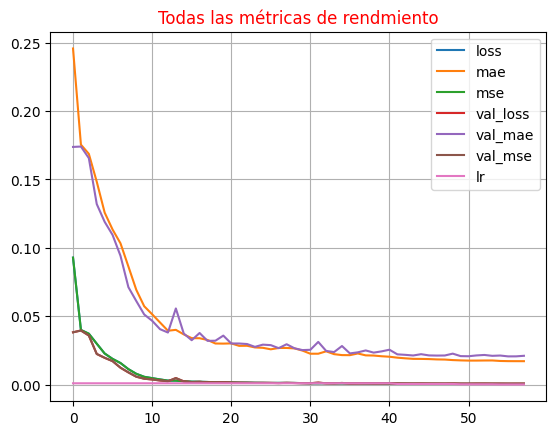

In [ ]:
# Creación y visualización de un gráfico de las métricas de rendimiento durante el entrenamiento

# Creación de un DataFrame con el historial de las métricas del modelo
hpd = pd.DataFrame(history.history)

# Creación de un gráfico para visualizar las métricas de rendimiento
hpd.plot()

# Asignación de título al gráfico
plt.title('Todas las métricas de rendimiento', c='r')

# Habilitación de las líneas de la grilla en el gráfico
plt.grid(True)

# Mostrar el gráfico
plt.show()

### ANN

In [ ]:
# Creación del modelo ANN con capas secuenciales
model_ANN = keras.models.Sequential([
                                     keras.layers.Dense(100, input_shape=(step_back,)),
                                     keras.layers.Dense(100),
                                     keras.layers.Dense(100),
                                     keras.layers.Dense(1)
])

# Mostrar un resumen de la arquitectura del modelo
model_ANN.summary()

# Compilación del modelo para la fase de entrenamiento
model_ANN.compile(loss="mse", optimizer="adam", metrics=['mae', 'mse'])

# Entrenamiento del modelo utilizando los datos de entrenamiento
# Se utiliza un historial (history) para almacenar la información del entrenamiento
history = model_ANN.fit(X_train1, Y_train1, epochs=N, batch_size=bsz, callbacks=callbacks, validation_split=0.2)


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 100)               1300      
                                                                 
 dense_13 (Dense)            (None, 100)               10100     
                                                                 
 dense_14 (Dense)            (None, 100)               10100     
                                                                 
 dense_15 (Dense)            (None, 1)                 101       
                                                                 
Total params: 21,601
Trainable params: 21,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
25/25 [==============================] - 2s 11ms/step - loss: 0.1178 - mae: 0.2537 - mse: 0.1178 - val_loss: 0.0149 - val_mae: 0.0965 - val_mse: 0.0149 - lr: 0.0010
Epoc

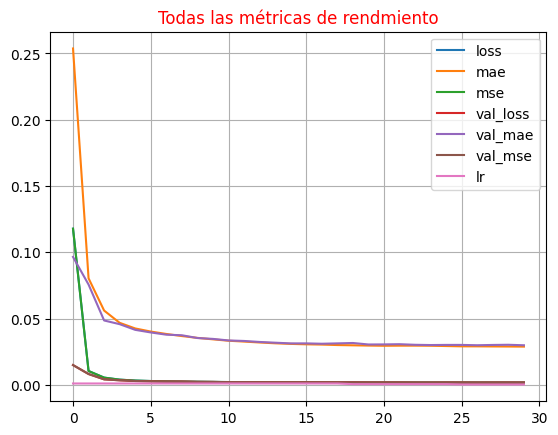

In [ ]:
# Visualización del historial de métricas de rendimiento durante el entrenamiento

# Crear un DataFrame con el historial de métricas del entrenamiento
hpd = pd.DataFrame(history.history)

# Crear una gráfica de líneas para las métricas de rendimiento
hpd.plot()

# Establecer el título del gráfico
plt.title('Todas las métricas de rendimiento', color='r')

# Habilitar las líneas de la cuadrícula en el gráfico
plt.grid(True)

# Mostrar el gráfico
plt.show()

### GRU

In [ ]:
# Creación del modelo GRU con capas secuenciales
model_GRU = keras.models.Sequential([
                                     keras.layers.GRU(100, return_sequences=True, input_shape=(step_back, 1)),
                                     keras.layers.GRU(100, return_sequences=True),
                                     keras.layers.GRU(100, return_sequences=True),
                                     keras.layers.GRU(1)
])

# Mostrar un resumen de la arquitectura del modelo
model_GRU.summary()

# Compilación del modelo para la fase de entrenamiento
metrics = ['mae', 'mse']
model_GRU.compile(loss="mse", optimizer="adam", metrics=metrics)

# Entrenamiento del modelo utilizando los datos de entrenamiento
# Se utiliza un historial (history) para almacenar la información del entrenamiento
history = model_GRU.fit(X_train1, Y_train1, epochs=N, batch_size=bsz, callbacks=callbacks, validation_split=0.2)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_8 (GRU)                 (None, 12, 100)           30900     
                                                                 
 gru_9 (GRU)                 (None, 12, 100)           60600     
                                                                 
 gru_10 (GRU)                (None, 12, 100)           60600     
                                                                 
 gru_11 (GRU)                (None, 1)                 309       
                                                                 
Total params: 152,409
Trainable params: 152,409
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
25/25 [==============================] - 8s 60ms/step - loss: 0.0695 - mae: 0.2080 - mse: 0.0695 - val_loss: 0.0284 - val_mae: 0.1423 - val_mse: 0.0284 - lr: 0.0010
Ep

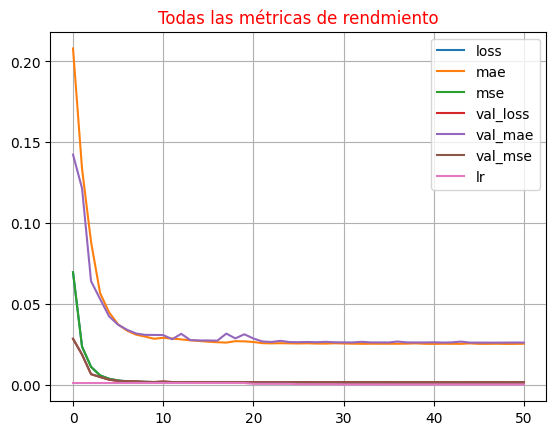

In [ ]:
# Creación del DataFrame de historial de entrenamiento y visualización de métricas

# Crear un DataFrame con el historial de entrenamiento
hpd = pd.DataFrame(history.history)

# Generar un gráfico con las métricas de rendimiento a lo largo de las épocas de entrenamiento
hpd.plot()

# Agregar un título al gráfico
plt.title('Todas las métricas de rendimiento', c='r')

# Habilitar la cuadrícula en el gráfico
plt.grid(True)

# Mostrar el gráfico
plt.show()

### RNN

In [ ]:
# Creación del modelo de red neuronal con capas SimpleRNN
model_RNN = keras.models.Sequential([
                                     keras.layers.SimpleRNN(100, return_sequences=True, input_shape=(step_back, 1)),
                                     keras.layers.SimpleRNN(100, return_sequences=True),
                                     keras.layers.SimpleRNN(100, return_sequences=True),
                                     keras.layers.SimpleRNN(1)
])

# Mostrar un resumen de la arquitectura del modelo
model_RNN.summary()

# Compilación del modelo para la fase de entrenamiento
metrics = ['mae', 'mse']
model_RNN.compile(loss="mse", optimizer="adam", metrics=metrics)

# Entrenamiento del modelo utilizando los datos de entrenamiento
# Se utiliza un historial (history) para almacenar la información del entrenamiento
history = model_RNN.fit(X_train1, Y_train1, epochs=N, batch_size=bsz, callbacks=callbacks, validation_split=0.2)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_8 (SimpleRNN)    (None, 12, 100)           10200     
                                                                 
 simple_rnn_9 (SimpleRNN)    (None, 12, 100)           20100     
                                                                 
 simple_rnn_10 (SimpleRNN)   (None, 12, 100)           20100     
                                                                 
 simple_rnn_11 (SimpleRNN)   (None, 1)                 102       
                                                                 
Total params: 50,502
Trainable params: 50,502
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
25/25 [==============================] - 6s 70ms/step - loss: 0.1963 - mae: 0.3172 - mse: 0.1963 - val_loss: 0.0878 - val_mae: 0.2420 - val_mse: 0.0878 - lr: 0.0010
Epoc

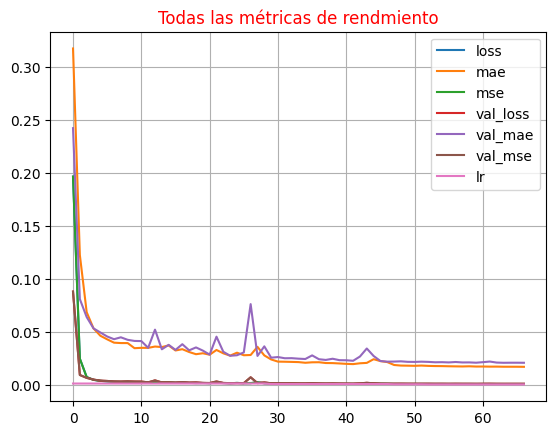

In [ ]:
# Creación del DataFrame de historial de entrenamiento y visualización de métricas

# Crear un DataFrame con el historial de entrenamiento
hpd = pd.DataFrame(history.history)

# Generar un gráfico con las métricas de rendimiento a lo largo de las épocas de entrenamiento
hpd.plot()

# Agregar un título al gráfico
plt.title('Todas las métricas de rendimiento', c='r')

# Habilitar la cuadrícula en el gráfico
plt.grid(True)

# Mostrar el gráfico
plt.show()

## Rendimiento

124/124 [==============================] - 0s 1ms/step


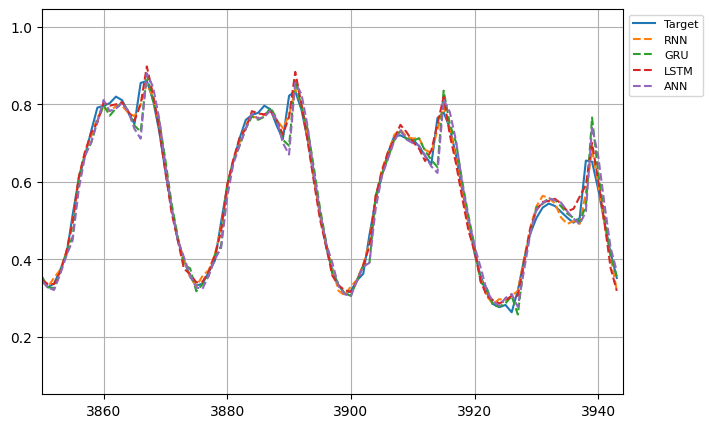

╒═════════════╤═════════════╤═════════════╤═════════════╤════════════╕
│ Metrics     │         RNN │         GRU │        LSTM │        ANN │
╞═════════════╪═════════════╪═════════════╪═════════════╪════════════╡
│ MSE         │ 0.02961     │ 0.03846     │ 0.02742     │ 0.04137    │
├─────────────┼─────────────┼─────────────┼─────────────┼────────────┤
│ RMSE        │ 0.000876897 │ 0.00147952  │ 0.000751701 │ 0.00171115 │
├─────────────┼─────────────┼─────────────┼─────────────┼────────────┤
│ MAE         │ 0.02212     │ 0.02734     │ 0.02138     │ 0.02975    │
├─────────────┼─────────────┼─────────────┼─────────────┼────────────┤
│ R2          │ 0.97826     │ 0.96332     │ 0.98136     │ 0.95758    │
├─────────────┼─────────────┼─────────────┼─────────────┼────────────┤
│ cnSMAPE     │ 0.96366     │ 0.95641     │ 0.96324     │ 0.9516     │
├─────────────┼─────────────┼─────────────┼─────────────┼────────────┤
│ P_Value_PS  │ 0           │ 0           │ 0           │ 0          │
├─────

In [ ]:
# Realizar predicciones utilizando los modelos entrenados
forecasting_RNN = model_RNN.predict(X_test1)
forecasting_GRU = model_GRU.predict(X_test1)
forecasting_LSTM = model_LSTM.predict(X_test1)
forecasting_ANN = model_ANN.predict(X_test1)

# Crear una lista de las predicciones de los diferentes modelos
forecasting_DL2 = [forecasting_RNN, forecasting_GRU, forecasting_LSTM, forecasting_ANN.reshape(forecasting_ANN.shape[0], 1)]

# Nombres de los modelos para su posterior uso en la gráfica
model_names_DL = ['RNN', 'GRU', 'LSTM', 'ANN']

# Crear una figura para mostrar la comparación entre las predicciones y los valores reales
plt.figure(figsize=(7.5, 5))
plt.plot(Y_test1, label='Target')  # Valores reales
for i in range(len(forecasting_DL2)):
    plt.plot(forecasting_DL2[i], label=model_names_DL[i], linestyle='--')  # Predicciones de los modelos
plt.xlim(3850, len(forecasting_DL2[i]))  # Ajustar límites del eje x
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize='8')  # Agregar leyenda
plt.grid()  # Agregar cuadrícula
plt.show()  # Mostrar la gráfica

# Calcular métricas de rendimiento para cada modelo y almacenar en tablas
col_names = ['Metrics', 'RNN', 'GRU', 'LSTM', 'ANN']
MSE, RMSE, MAE, R2, cnSMAPE, P_Value_PS, P_Value_TT, P_Value_Var = ["MSE"], ["RMSE"], ["MAE"], ["R2"], ['cnSMAPE'], ['P_Value_PS'], ['P_Value_TT'], ['P_Value_Var']

for k in range(4):
    MSE.append(round(mean_squared_error(Y_test1, forecasting_DL2[k], squared=False), 5))
    RMSE.append(mean_squared_error(Y_test1, forecasting_DL2[k], squared=True))
    MAE.append(round(mean_absolute_error(Y_test1, forecasting_DL2[k]), 5))
    R2.append(round(r2_score(Y_test1, forecasting_DL2[k]), 5))
    mape = mean_absolute_percentage_error(Y_test1, forecasting_DL2[k])
    smape = 2 * mape * 100 / (100 - mape)
    cnSMAPE.append(round(1 - (smape / 2), 5))
    correlation, p_value = stats.pearsonr(Y_test1.reshape(len(Y_test1)), forecasting_DL2[k].reshape(len(Y_test1)))
    P_Value_PS.append(p_value)
    correlation, p_value = stats.ttest_ind(Y_test1.reshape(len(Y_test1)), forecasting_DL2[k].reshape(len(Y_test1)))
    P_Value_TT.append(p_value)
    statistic, p_value3 = bartlett(Y_test1.reshape(len(Y_test1)), forecasting_DL2[k].reshape(len(Y_test1)))
    P_Value_Var.append(p_value3)

# Crear una tabla con las métricas de rendimiento para cada modelo
tablas = [MSE, RMSE, MAE, R2, cnSMAPE, P_Value_PS, P_Value_TT, P_Value_Var]

# Imprimir la tabla utilizando el formato "fancy_grid"
print(tabulate(tablas, headers=col_names, tablefmt="fancy_grid"))

In [ ]:
# Convertir la lista de tablas en un DataFrame
tablas = pd.DataFrame(tablas)

# Guardar el DataFrame en un archivo Excel
tablas.to_excel("/content/DL_U_12.xlsx")

# Descargar el archivo Excel
files.download("/content/DL_U_12.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## TimeStep =18

### Conjunto de Entrenamiento


In [ ]:
# Definición del tamaño de ventana para el procesamiento secuencial
step_back = 18

# Creación de las particiones X, Y utilizando la función TrainingSet con el tamaño de ventana dado
X1, Y1 = TrainingSet(Ts1, step_back)

# Definición del porcentaje de partición Train-Test
Part = 0.8

# Creación de la partición para el conjunto de prueba (Test) y el conjunto de entrenamiento (Train) para la serie X
X_test1 = X1[int(len(X1) * 0.8):]
X_train1 = X1[:int(len(X1) * 0.8)]

# Creación de la partición para el conjunto de prueba (Test) y el conjunto de entrenamiento (Train) para la serie Y
Y_test1 = Y1[int(len(Y1) * 0.8):]
Y_train1 = Y1[:int(len(Y1) * 0.8)]

### LSTM

In [ ]:
# Creación del modelo LSTM con capas secuenciales
model_LSTM = keras.models.Sequential([
                                     keras.layers.LSTM(100, return_sequences=True, input_shape=(step_back,1)),
                                     keras.layers.LSTM(100, return_sequences=True),
                                     keras.layers.LSTM(100, return_sequences=True),
                                     keras.layers.LSTM(1)
])

# Mostrar un resumen de la arquitectura del modelo
model_LSTM.summary()

# Compilación del modelo para la fase de entrenamiento
model_LSTM.compile(loss="mse", optimizer="adam", metrics=['mae', 'mse'])

# Entrenamiento del modelo utilizando los datos de entrenamiento
# Se utiliza un historial (history) para almacenar la información del entrenamiento
history = model_LSTM.fit(X_train1, Y_train1, epochs=N, batch_size=bsz, callbacks=callbacks, validation_split=0.2)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 18, 100)           40800     
                                                                 
 lstm_21 (LSTM)              (None, 18, 100)           80400     
                                                                 
 lstm_22 (LSTM)              (None, 18, 100)           80400     
                                                                 
 lstm_23 (LSTM)              (None, 1)                 408       
                                                                 
Total params: 202,008
Trainable params: 202,008
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
25/25 [==============================] - 8s 69ms/step - loss: 0.0804 - mae: 0.2315 - mse: 0.0804 - val_loss: 0.0381 - val_mae: 0.1736 - val_mse: 0.0381 - lr: 0.0010
Ep

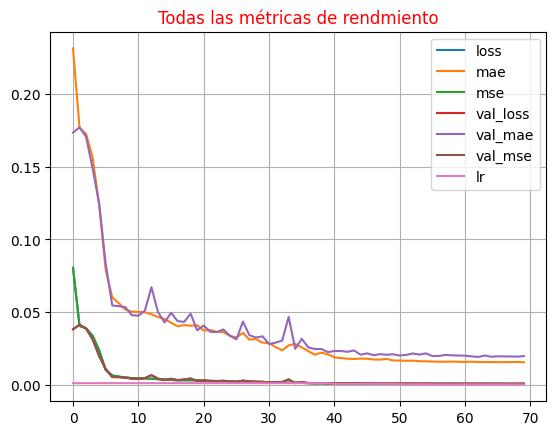

In [ ]:
# Creación y visualización de un gráfico de las métricas de rendimiento durante el entrenamiento

# Creación de un DataFrame con el historial de las métricas del modelo
hpd = pd.DataFrame(history.history)

# Creación de un gráfico para visualizar las métricas de rendimiento
hpd.plot()

# Asignación de título al gráfico
plt.title('Todas las métricas de rendimiento', c='r')

# Habilitación de las líneas de la grilla en el gráfico
plt.grid(True)

# Mostrar el gráfico
plt.show()

### ANN

In [ ]:
# Creación del modelo ANN con capas secuenciales
model_ANN = keras.models.Sequential([
                                     keras.layers.Dense(100, input_shape=(step_back,)),
                                     keras.layers.Dense(100),
                                     keras.layers.Dense(100),
                                     keras.layers.Dense(1)
])

# Mostrar un resumen de la arquitectura del modelo
model_ANN.summary()

# Compilación del modelo para la fase de entrenamiento
model_ANN.compile(loss="mse", optimizer="adam", metrics=['mae', 'mse'])

# Entrenamiento del modelo utilizando los datos de entrenamiento
# Se utiliza un historial (history) para almacenar la información del entrenamiento
history = model_ANN.fit(X_train1, Y_train1, epochs=N, batch_size=bsz, callbacks=callbacks, validation_split=0.2)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 100)               1900      
                                                                 
 dense_17 (Dense)            (None, 100)               10100     
                                                                 
 dense_18 (Dense)            (None, 100)               10100     
                                                                 
 dense_19 (Dense)            (None, 1)                 101       
                                                                 
Total params: 22,201
Trainable params: 22,201
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
25/25 [==============================] - 2s 12ms/step - loss: 0.0482 - mae: 0.1688 - mse: 0.0482 - val_loss: 0.0193 - val_mae: 0.1139 - val_mse: 0.0193 - lr: 0.0010
Epoc

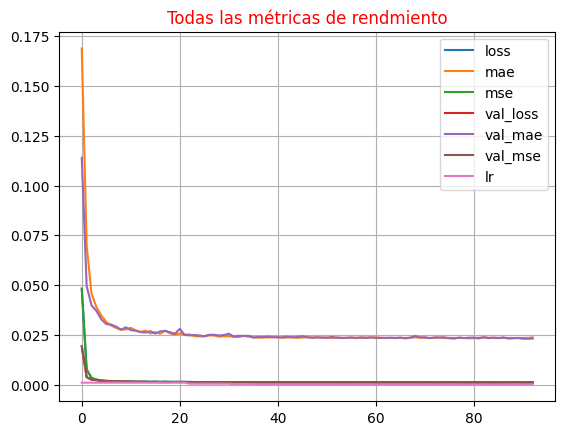

In [ ]:
# Visualización del historial de métricas de rendimiento durante el entrenamiento

# Crear un DataFrame con el historial de métricas del entrenamiento
hpd = pd.DataFrame(history.history)

# Crear una gráfica de líneas para las métricas de rendimiento
hpd.plot()

# Establecer el título del gráfico
plt.title('Todas las métricas de rendimiento', color='r')

# Habilitar las líneas de la cuadrícula en el gráfico
plt.grid(True)

# Mostrar el gráfico
plt.show()

### GRU

In [ ]:
# Creación del modelo GRU con capas secuenciales
model_GRU = keras.models.Sequential([
                                     keras.layers.GRU(100, return_sequences=True, input_shape=(step_back, 1)),
                                     keras.layers.GRU(100, return_sequences=True),
                                     keras.layers.GRU(100, return_sequences=True),
                                     keras.layers.GRU(1)
])

# Mostrar un resumen de la arquitectura del modelo
model_GRU.summary()

# Compilación del modelo para la fase de entrenamiento
metrics = ['mae', 'mse']
model_GRU.compile(loss="mse", optimizer="adam", metrics=metrics)

# Entrenamiento del modelo utilizando los datos de entrenamiento
# Se utiliza un historial (history) para almacenar la información del entrenamiento
history = model_GRU.fit(X_train1, Y_train1, epochs=N, batch_size=bsz, callbacks=callbacks, validation_split=0.2)

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_12 (GRU)                (None, 18, 100)           30900     
                                                                 
 gru_13 (GRU)                (None, 18, 100)           60600     
                                                                 
 gru_14 (GRU)                (None, 18, 100)           60600     
                                                                 
 gru_15 (GRU)                (None, 1)                 309       
                                                                 
Total params: 152,409
Trainable params: 152,409
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
25/25 [==============================] - 7s 60ms/step - loss: 0.0700 - mae: 0.2120 - mse: 0.0700 - val_loss: 0.0325 - val_mae: 0.1537 - val_mse: 0.0325 - lr: 0.0010
Ep

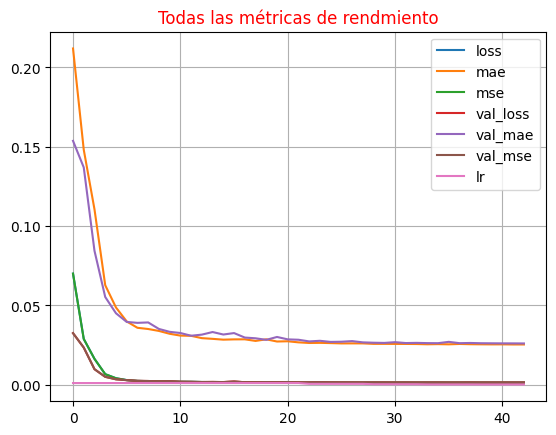

In [ ]:
# Creación del DataFrame de historial de entrenamiento y visualización de métricas

# Crear un DataFrame con el historial de entrenamiento
hpd = pd.DataFrame(history.history)

# Generar un gráfico con las métricas de rendimiento a lo largo de las épocas de entrenamiento
hpd.plot()

# Agregar un título al gráfico
plt.title('Todas las métricas de rendimiento', c='r')

# Habilitar la cuadrícula en el gráfico
plt.grid(True)

# Mostrar el gráfico
plt.show()

### RNN

In [ ]:
# Creación del modelo de red neuronal con capas SimpleRNN
model_RNN = keras.models.Sequential([
                                     keras.layers.SimpleRNN(100, return_sequences=True, input_shape=(step_back, 1)),
                                     keras.layers.SimpleRNN(100, return_sequences=True),
                                     keras.layers.SimpleRNN(100, return_sequences=True),
                                     keras.layers.SimpleRNN(1)
])

# Mostrar un resumen de la arquitectura del modelo
model_RNN.summary()

# Compilación del modelo para la fase de entrenamiento
metrics = ['mae', 'mse']
model_RNN.compile(loss="mse", optimizer="adam", metrics=metrics)

# Entrenamiento del modelo utilizando los datos de entrenamiento
# Se utiliza un historial (history) para almacenar la información del entrenamiento
history = model_RNN.fit(X_train1, Y_train1, epochs=N, batch_size=bsz, callbacks=callbacks, validation_split=0.2)

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_12 (SimpleRNN)   (None, 18, 100)           10200     
                                                                 
 simple_rnn_13 (SimpleRNN)   (None, 18, 100)           20100     
                                                                 
 simple_rnn_14 (SimpleRNN)   (None, 18, 100)           20100     
                                                                 
 simple_rnn_15 (SimpleRNN)   (None, 1)                 102       
                                                                 
Total params: 50,502
Trainable params: 50,502
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
25/25 [==============================] - 6s 88ms/step - loss: 0.0511 - mae: 0.1684 - mse: 0.0511 - val_loss: 0.0171 - val_mae: 0.1092 - val_mse: 0.0171 - lr: 0.0010
Epoc

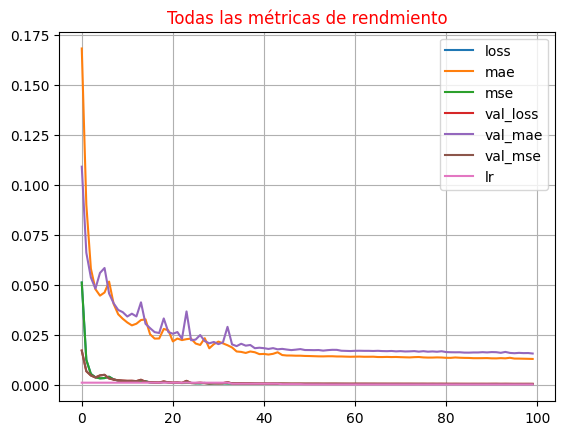

In [ ]:
# Creación del DataFrame de historial de entrenamiento y visualización de métricas

# Crear un DataFrame con el historial de entrenamiento
hpd = pd.DataFrame(history.history)

# Generar un gráfico con las métricas de rendimiento a lo largo de las épocas de entrenamiento
hpd.plot()

# Agregar un título al gráfico
plt.title('Todas las métricas de rendimiento', c='r')

# Habilitar la cuadrícula en el gráfico
plt.grid(True)

# Mostrar el gráfico
plt.show()

## Rendimiento

124/124 [==============================] - 0s 1ms/step


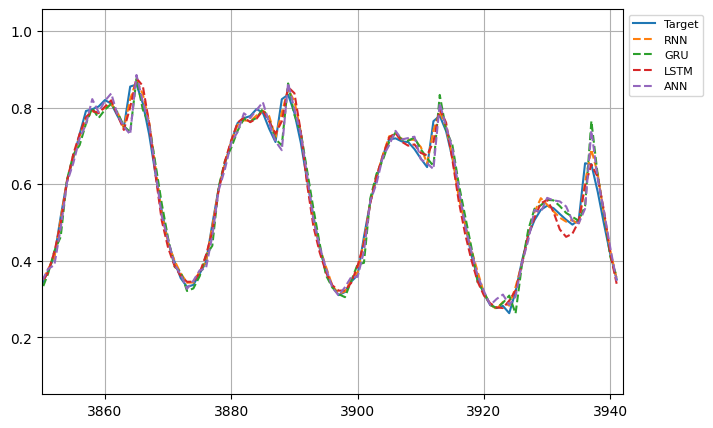

╒═════════════╤═════════════╤═════════════╤═════════════╤════════════╕
│ Metrics     │         RNN │         GRU │        LSTM │        ANN │
╞═════════════╪═════════════╪═════════════╪═════════════╪════════════╡
│ MSE         │ 0.02144     │ 0.03819     │ 0.02698     │ 0.0334     │
├─────────────┼─────────────┼─────────────┼─────────────┼────────────┤
│ RMSE        │ 0.000459483 │ 0.00145833  │ 0.000728043 │ 0.00111556 │
├─────────────┼─────────────┼─────────────┼─────────────┼────────────┤
│ MAE         │ 0.01654     │ 0.02761     │ 0.02024     │ 0.02354    │
├─────────────┼─────────────┼─────────────┼─────────────┼────────────┤
│ R2          │ 0.98861     │ 0.96387     │ 0.98196     │ 0.97236    │
├─────────────┼─────────────┼─────────────┼─────────────┼────────────┤
│ cnSMAPE     │ 0.97248     │ 0.95589     │ 0.96476     │ 0.96181    │
├─────────────┼─────────────┼─────────────┼─────────────┼────────────┤
│ P_Value_PS  │ 0           │ 0           │ 0           │ 0          │
├─────

In [ ]:
# Realizar predicciones utilizando los modelos entrenados
forecasting_RNN = model_RNN.predict(X_test1)
forecasting_GRU = model_GRU.predict(X_test1)
forecasting_LSTM = model_LSTM.predict(X_test1)
forecasting_ANN = model_ANN.predict(X_test1)

# Crear una lista de las predicciones de los diferentes modelos
forecasting_DL2 = [forecasting_RNN, forecasting_GRU, forecasting_LSTM, forecasting_ANN.reshape(forecasting_ANN.shape[0], 1)]

# Nombres de los modelos para su posterior uso en la gráfica
model_names_DL = ['RNN', 'GRU', 'LSTM', 'ANN']

# Crear una figura para mostrar la comparación entre las predicciones y los valores reales
plt.figure(figsize=(7.5, 5))
plt.plot(Y_test1, label='Target')  # Valores reales
for i in range(len(forecasting_DL2)):
    plt.plot(forecasting_DL2[i], label=model_names_DL[i], linestyle='--')  # Predicciones de los modelos
plt.xlim(3850, len(forecasting_DL2[i]))  # Ajustar límites del eje x
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize='8')  # Agregar leyenda
plt.grid()  # Agregar cuadrícula
plt.show()  # Mostrar la gráfica

# Calcular métricas de rendimiento para cada modelo y almacenar en tablas
col_names = ['Metrics', 'RNN', 'GRU', 'LSTM', 'ANN']
MSE, RMSE, MAE, R2, cnSMAPE, P_Value_PS, P_Value_TT, P_Value_Var = ["MSE"], ["RMSE"], ["MAE"], ["R2"], ['cnSMAPE'], ['P_Value_PS'], ['P_Value_TT'], ['P_Value_Var']

for k in range(4):
    MSE.append(round(mean_squared_error(Y_test1, forecasting_DL2[k], squared=False), 5))
    RMSE.append(mean_squared_error(Y_test1, forecasting_DL2[k], squared=True))
    MAE.append(round(mean_absolute_error(Y_test1, forecasting_DL2[k]), 5))
    R2.append(round(r2_score(Y_test1, forecasting_DL2[k]), 5))
    mape = mean_absolute_percentage_error(Y_test1, forecasting_DL2[k])
    smape = 2 * mape * 100 / (100 - mape)
    cnSMAPE.append(round(1 - (smape / 2), 5))
    correlation, p_value = stats.pearsonr(Y_test1.reshape(len(Y_test1)), forecasting_DL2[k].reshape(len(Y_test1)))
    P_Value_PS.append(p_value)
    correlation, p_value = stats.ttest_ind(Y_test1.reshape(len(Y_test1)), forecasting_DL2[k].reshape(len(Y_test1)))
    P_Value_TT.append(p_value)
    statistic, p_value3 = bartlett(Y_test1.reshape(len(Y_test1)), forecasting_DL2[k].reshape(len(Y_test1)))
    P_Value_Var.append(p_value3)

# Crear una tabla con las métricas de rendimiento para cada modelo
tablas = [MSE, RMSE, MAE, R2, cnSMAPE, P_Value_PS, P_Value_TT, P_Value_Var]

# Imprimir la tabla utilizando el formato "fancy_grid"
print(tabulate(tablas, headers=col_names, tablefmt="fancy_grid"))

In [ ]:
# Convertir la lista de tablas en un DataFrame
tablas = pd.DataFrame(tablas)

# Guardar el DataFrame en un archivo Excel
tablas.to_excel("/content/DL_U_18.xlsx")

# Descargar el archivo Excel
files.download("/content/DL_U_18.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Tiempo

In [ ]:
# Cálculo del tiempo transcurrido

# Registrar el tiempo de finalización
fin = time.time()

# Calcular el tiempo transcurrido
tiempo_transcurrido = fin - inicio

# Imprimir el tiempo transcurrido en segundos
print("Tiempo transcurrido: ", tiempo_transcurrido, "segundos")

Tiempo transcurrido:  1120.9168691635132 segundos
